In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime


In [ ]:
# LOAD DATA
df = pd.read_csv("/Users/tungnguyenlam/Programming/projects/dataflow/analysis_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

print("Initial data shape:", df.shape)
df.head()


Initial data shape: (976243, 14)


,ID,Date,Units,Revenue,COGS,Profit,City,Region,Category,Segment,Product_Brand,Month,Year,Day
0,0,2013-07-31,12,19648.44,12309.747660,7338.692340,Austin,Central,Urban,Convenience,Pirum,7,2013,31
1,1,2014-03-12,16,20351.52,13497.128064,6854.391936,Torrance,West,Rural,Productivity,Natura,3,2014,12
2,2,2013-11-29,26,111367.62,91488.499830,19879.120170,Salem,East,Urban,Convenience,Currus,11,2013,29
3,3,2018-08-29,12,36280.44,21967.806420,14312.633580,Lithia Springs,East,Rural,Select,Pirum,8,2018,29
4,4,2013-04-27,14,55557.18,48645.866808,6911.313192,Troup,Central,Urban,Convenience,Natura,4,2013,27


In [ ]:
# PREPROCESSING & TRAIN/TEST SPLIT
# Aggregate revenue by date
df_timeseries = df.groupby('Date')['Revenue'].sum().reset_index()

df_timeseries_predict_2023 = pd.DataFrame({'Date': pd.date_range(start='2022-06-01', end='2023-07-01')})

# --- Optionally add cyclical date features (e.g., day of week, month)
df_timeseries['day_of_week'] = df_timeseries['Date'].dt.dayofweek  # Mon=0, Sun=6
df_timeseries['month'] = df_timeseries['Date'].dt.month            # 1-12
df_timeseries['day of month'] = df_timeseries['Date'].dt.day       # 1-31

df_timeseries_predict_2023['day_of_week'] = df_timeseries_predict_2023['Date'].dt.dayofweek  # Mon=0, Sun=6
df_timeseries_predict_2023['month'] = df_timeseries_predict_2023['Date'].dt.month            # 1-12
df_timeseries_predict_2023['day of month'] = df_timeseries_predict_2023['Date'].dt.day       # 1-31

# Create cyclical features for day_of_week and month
# day_of_week -> sin/cos with period=7
df_timeseries['dow_sin'] = np.sin(2 * np.pi * df_timeseries['day_of_week'] / 7)
df_timeseries['dow_cos'] = np.cos(2 * np.pi * df_timeseries['day_of_week'] / 7)

df_timeseries_predict_2023['dow_sin'] = np.sin(2 * np.pi * df_timeseries_predict_2023['day_of_week'] / 7)
df_timeseries_predict_2023['dow_cos'] = np.cos(2 * np.pi * df_timeseries_predict_2023['day_of_week'] / 7)

#day of month -> sin/cos with period=30
df_timeseries['dom_sin'] = np.sin(2 * np.pi * df_timeseries['day of month'] / 30)
df_timeseries['dom_cos'] = np.cos(2 * np.pi * df_timeseries['day of month'] / 30)

df_timeseries_predict_2023['dom_sin'] = np.sin(2 * np.pi * df_timeseries_predict_2023['day of month'] / 30)
df_timeseries_predict_2023['dom_cos'] = np.cos(2 * np.pi * df_timeseries_predict_2023['day of month'] / 30)

# month => sin/cos with period=12
df_timeseries['month_sin'] = np.sin(2 * np.pi * df_timeseries['month'] / 12)
df_timeseries['month_cos'] = np.cos(2 * np.pi * df_timeseries['month'] / 12)

df_timeseries_predict_2023['month_sin'] = np.sin(2 * np.pi * df_timeseries_predict_2023['month'] / 12)
df_timeseries_predict_2023['month_cos'] = np.cos(2 * np.pi * df_timeseries_predict_2023['month'] / 12)

# log transform revenue
df_timeseries['Revenue_log'] = np.log1p(df_timeseries['Revenue'])

df_timeseries_predict_2023['Revenue'] = 0
df_timeseries_predict_2023['Revenue_log'] = 0

# split by year
train_df = df_timeseries[df_timeseries['Date'].dt.year <= 2020].copy()
test_df = df_timeseries[df_timeseries['Date'].dt.year > 2020].copy()

print("Train size:", train_df.shape, "Test size:", test_df.shape)
print("Predict size", df_timeseries_predict_2023.shape)

Train size: (3718, 12) Test size: (535, 12)
Predict size (396, 12)


In [ ]:
# SCALING
feature_cols = ['Revenue_log', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'dom_sin', 'dom_cos']

scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])
df_timeseries_predict_2023[feature_cols] = scaler.transform(df_timeseries_predict_2023[feature_cols])

In [ ]:
# create sequences using multiple features
def create_sequences_multifeature(df, feature_columns, lookback=30):
    X, y = [], []
    data = df[feature_columns].values
    target = df['Revenue_log'].values  # using 'Revenue_log' as  target
    for i in range(len(df) - lookback):
        X.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)


# lookback window
lookback = 30

# create training and testing sequences with multiple features
X_train, y_train = create_sequences_multifeature(train_df, feature_cols, lookback)
X_test, y_test = create_sequences_multifeature(test_df, feature_cols, lookback)
X_predict, _ = create_sequences_multifeature(df_timeseries_predict_2023, feature_cols, lookback)


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3688, 30, 7)
X_test shape: (505, 30, 7)


In [ ]:
num_features = X_train.shape[2]  
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))
X_predict = X_predict.reshape((X_predict.shape[0], X_predict.shape[1], num_features))

print(np.shape(X_train))
print(np.shape(X_test))
print("X_predict shape: ", np.shape(X_predict))



(3688, 30, 7)
(505, 30, 7)
X_predict shape:  (366, 30, 7)


In [ ]:
# Create RNN model
def create_rnn(input_shape):
    model = Sequential([
        SimpleRNN(300, activation='relu', return_sequences=False, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  

rnn_model = create_rnn(input_shape)
rnn_model.fit(X_train, y_train, epochs=38, batch_size=20, verbose=1)



Epoch 1/38


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0357
Epoch 2/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0120
Epoch 3/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0112
Epoch 4/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0090
Epoch 5/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0087
Epoch 6/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0077
Epoch 7/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0068
Epoch 8/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0071
Epoch 9/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0077
Epoch 10/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0069
Epoch 11/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0075
Epoch 12/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0064
Epoch 13/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0063
Epoch 14/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0064
Epoch 15/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step 

In [8]:
# Create LSTM model
def create_lstm(input_shape):
    model = Sequential([
        LSTM(300, activation='relu', return_sequences=False, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = create_lstm(input_shape)
lstm_model.summary()

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=38, batch_size=20, verbose=1)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300)            │       369,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,901 (1.41 MB)

 Trainable params: 369,901 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.0447
Epoch 2/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.0148
Epoch 3/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.0137
Epoch 4/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - loss: 0.0130
Epoch 5/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 0.0117
Epoch 6/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0127
Epoch 7/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 0.0130
Epoch 8/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0099
Epoch 9/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 0.0111
Epoch 10/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0115
Epoch 11/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0101
Epoch 12/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.0101
Epoch 13/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 0.0099
Epoch 14/38
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0096
Epoch 15/38
185/185 ━━━━━━━━━

In [ ]:

# MAKE PREDICTIONS
y_pred_rnn = rnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test)

# INVERSE TRANSFORM PREDICTIONS
y_test_inv = np.expm1(y_test)       
y_pred_rnn_inv = np.expm1(y_pred_rnn)
y_pred_lstm_inv = np.expm1(y_pred_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


RNN - MSE: 0.015292100826890757, R2: 0.4787184778096144, MAPE: 21.205975232235986
LSTM - MSE: 0.014612593070668745, R2: 0.501881733238895, MAPE: 21.920474225727975


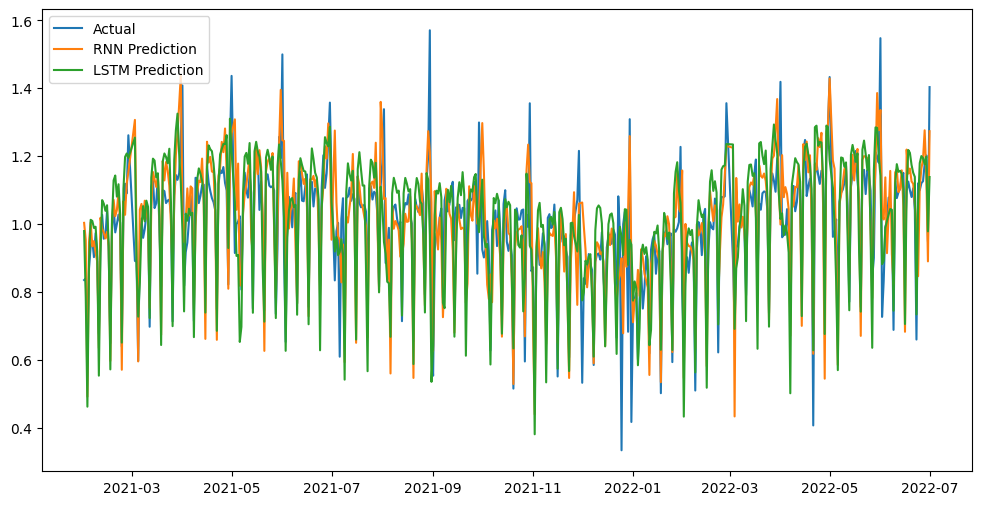

In [10]:
# Compute metrics
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, r2, mape

mse_rnn, r2_rnn, mape_rnn = compute_metrics(y_test_inv, y_pred_rnn_inv)
mse_lstm, r2_lstm, mape_lstm = compute_metrics(y_test_inv, y_pred_lstm_inv)

# Print metrics
print(f"RNN - MSE: {mse_rnn}, R2: {r2_rnn}, MAPE: {mape_rnn}")
print(f"LSTM - MSE: {mse_lstm}, R2: {r2_lstm}, MAPE: {mape_lstm}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(test_df['Date'][lookback:], y_test_inv, label='Actual')
plt.plot(test_df['Date'][lookback:], y_pred_rnn_inv, label='RNN Prediction')
plt.plot(test_df['Date'][lookback:], y_pred_lstm_inv, label='LSTM Prediction')
plt.legend()
plt.show()

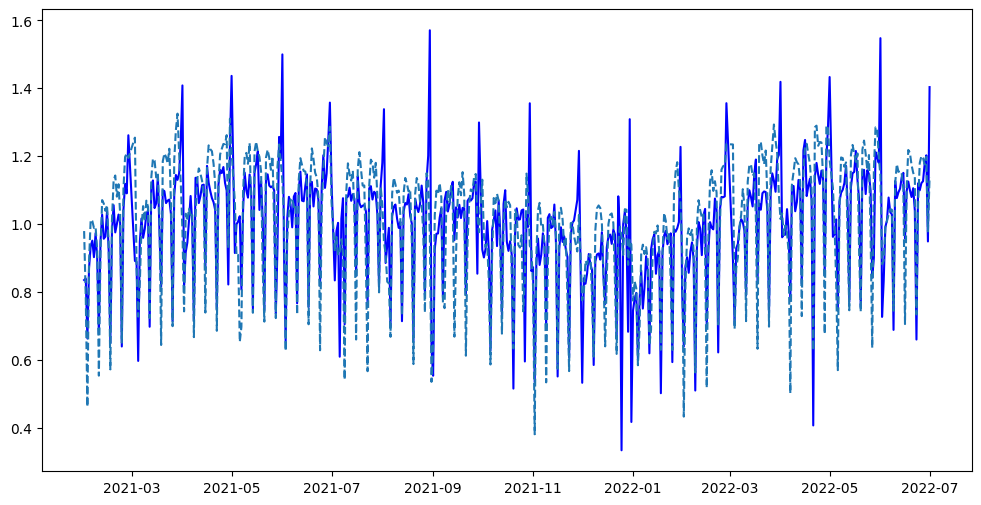

In [11]:
plt.figure(figsize=(12,6))
plt.plot(test_df['Date'][lookback:], y_test_inv, label='Actual 2021-2022', color='blue')
plt.plot(test_df['Date'][lookback:], y_pred_lstm_inv, label='LSTM Prediction 2021-2022', linestyle='dashed')

In [12]:
lstm_model_pre_2023 = lstm_model
lstm_model_pre_2023.fit(X_test, y_test, epochs=15, batch_size=16, verbose=1)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0020
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021
Epoch 9/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016
Epoch 10/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0022
Epoch 11/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025
Epoch 12/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018
Epoch 13/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0019
Epoch 14/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018
Epoch 15/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016


In [13]:
lstm_model_pre_2023.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1)
lstm_model_pre_2023.fit(X_test, y_test, epochs=1, batch_size=1, verbose=1)

y_pred_lstm_2023 = lstm_model_pre_2023.predict(X_predict)
print("Shape y_pred_lstm_2023 ", np.shape(y_pred_lstm_2023))

y_pred_lstm_2023_inv = np.expm1(y_pred_lstm_2023)

#replace outlier (> max df['Revenue'] and > 80% quartile) with 80% quartile
df['Revenue'].describe()
df['Revenue'].quantile(0.8)
df['Revenue'].max()
y_pred_lstm_2023_inv[y_pred_lstm_2023_inv > df['Revenue'].quantile(0.8)] = df['Revenue'].quantile(0.8)
y_pred_lstm_2023_inv[y_pred_lstm_2023_inv > df['Revenue'].max()] = df['Revenue'].quantile(0.8)

print("Shape y_pred_lstm_2023_inv", np.shape(y_pred_lstm_2023_inv))
print(y_pred_lstm_2023_inv)

3688/3688 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 0.0175
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0040
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape y_pred_lstm_2023  (366, 1)
Shape y_pred_lstm_2023_inv (366, 1)
[[1.2441763 ]
 [0.928369  ]
 [0.76187104]
 [0.79775375]
 [0.9339394 ]
 [1.0624166 ]
 [1.0732758 ]
 [1.0043819 ]
 [0.81387055]
 [0.71036524]
 [0.733176  ]
 [0.8486611 ]
 [0.99003506]
 [1.0454248 ]
 [1.0043594 ]
 [0.8652422 ]
 [0.7638475 ]
 [0.7839936 ]
 [0.92158157]
 [1.0992042 ]
 [1.1891396 ]
 [1.2053388 ]
 [1.0571176 ]
 [0.934964  ]
 [0.98284245]
 [1.1301342 ]
 [1.2821515 ]
 [1.3389285 ]
 [1.2092133 ]
 [0.9415511 ]
 [0.76944184]
 [0.8024141 ]
 [0.9279617 ]
 [1.0698012 ]
 [1.0842328 ]
 [0.9926149 ]
 [0.79668826]
 [0.69214153]
 [0.70764256]
 [0.8128271 ]
 [0.93297   ]
 [0.97201395]
 [0.8934808 ]
 [0.77760744]
 [0.7026726 ]
 [0.7203809 ]
 [0.82969856]
 [0.964676  ]
 [1.0240251 ]
 [0.97628766]
 [0.8903078 ]
 [0.82689273]
 [0.87338597]
 [1.0233593 ]
 [1.1890459 ]
 [1.

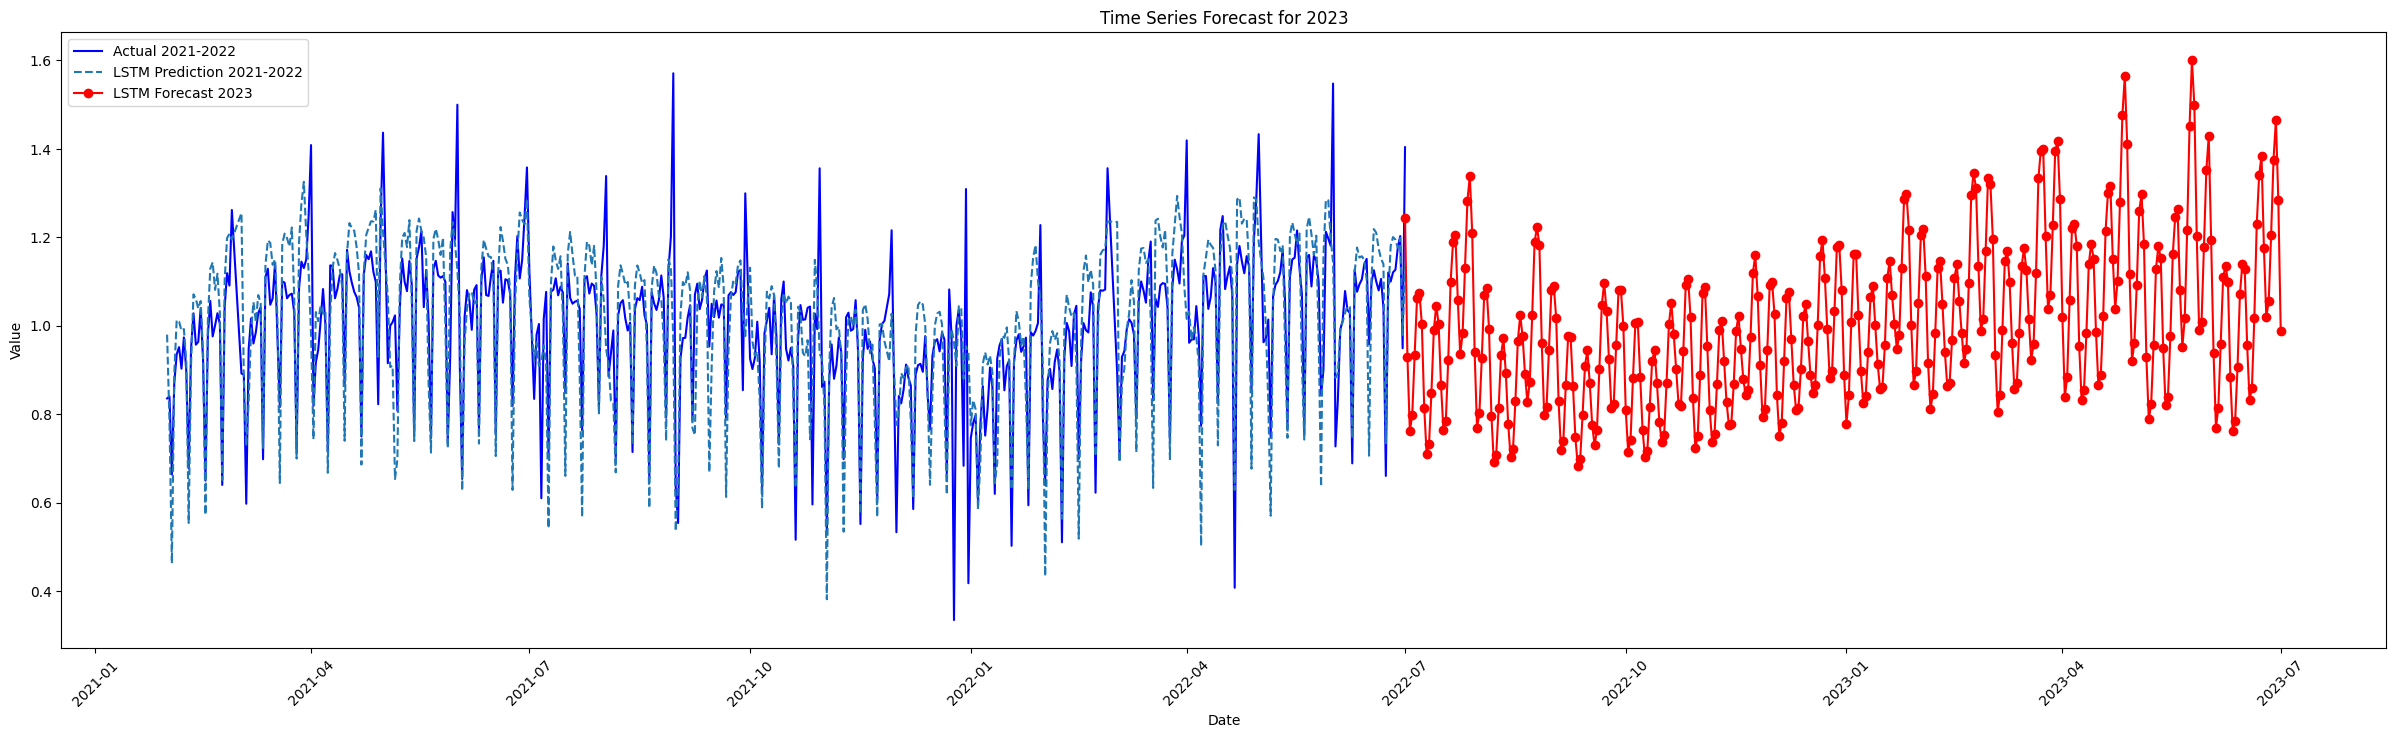

In [14]:

# Generate date range for 2023 predictions
future_dates = pd.date_range(start="2022-07-01", end="2023-07-01", freq="D")

# Plot results
plt.figure(figsize=(30,8))
plt.plot(test_df['Date'][lookback:], y_test_inv, label='Actual 2021-2022', color='blue')
plt.plot(test_df['Date'][lookback:], y_pred_lstm_inv, label='LSTM Prediction 2021-2022', linestyle='dashed')
plt.plot(future_dates, y_pred_lstm_2023_inv, label="LSTM Forecast 2023",marker='o', color='red')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Forecast for 2023")
plt.xticks(rotation=45)
plt.show()

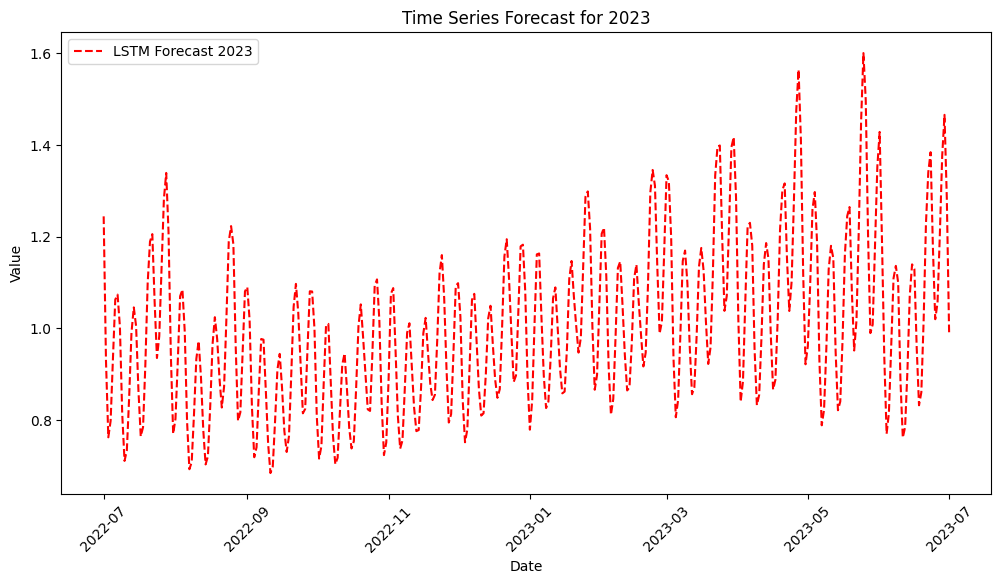

In [15]:
plt.figure(figsize=(12,6))

plt.plot(future_dates, y_pred_lstm_2023_inv, label="LSTM Forecast 2023", linestyle='--', color='red')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Forecast for 2023")
plt.xticks(rotation=45)
plt.show()
